In [1]:
%matplotlib inline
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import re
import pickle
import pandas as pd
import csv
import os
import time
import datetime
from tensorflow.contrib import learn
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import clear_output, Image, display, HTML

In [2]:
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

In [3]:
"""
    Train/test file separated, use in Supervised Phase
    """
def load_data_and_labels(train_data_file, test_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    train_data = pd.read_csv(train_data_file, sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['id', 'language', 'label', 'text'])
    test_data = pd.read_csv(test_data_file, sep='\t', quoting=csv.QUOTE_NONE, header=None, names=['id', 'language', 'label', 'text'])

    x_train = train_data['text'].tolist()
    y_train = train_data['label'].tolist()

    x_test = test_data['text'].tolist()
    y_test = test_data['label'].tolist()
    
    x_train = [s.strip() for s in x_train]
    x_test = [s.strip() for s in x_test]
    
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    
    y_train_encoding = [label_encoding[label] for label in y_train]    
    y_test_encoding = [label_encoding[label] for label in y_test]

    return [x_train, y_train_encoding, x_test, y_test_encoding]

"""Load file without using pandas
"""
def load_without_pandas(paths, numbers={}):
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    i=0
    X = []
    y = []
    for path in paths:
        try:
            n = numbers[path]
        except KeyError:
            n = 0
        i=0
        with open(path, 'r', encoding='utf8') as f:
            for line in f:
                if n and i >= n:
                    break
                i += 1
                splits = line.split('\t')
                y.append(label_encoding[splits[2]])
                X.append(splits[3].rstrip())
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return [X_train, y_train, X_test, y_test]

"""
    One single data, use in Distance-supervised Phase
    """
def transform_data_and_labels(data):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    
    x = np.array(data['text'].tolist())
    y = data['label'].tolist()
    
    # encoding label
    label_encoding = {'neutral':0, 'positive':1, 'negative':2}
    y = [label_encoding[label] for label in y]    
    
    
    y = np.array(y)
    
    # Randomly shuffle data
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]

    # Split train/test set
    # maybe we can use cross-validation to improve
    dev_sample_index = -1 * int(0.1 * float(len(y)))
    x_train, x_test = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_test = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
    print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
    
    return [x_train, y_train, x_test, y_test]

"""Tokenize train and test tweets, find the maximum length of tweetm,
    and find all tokens seen in the word dict"""
def tokenize_tweet(train_tweets, test_tweets, word_dict):
    all_tokens = {}
    dropped = 0
    # max_document_length = max([len(x.split(" ")) for x in x_train_sentence])
    ppl_re = re.compile(r'@\S*')
    url_re = re.compile(r'http\S+')
    esc_re = re.compile(r'\\u')
    tknzr = TweetTokenizer()
    # tknzr = TweetTokenizer(reduce_len=True)
    
    tokenized_tweets_all = []
    max_document_length = 0
    dropped = 0
    for tweets in [train_tweets, test_tweets]:
        tweets = [url_re.sub('URLTOK', ppl_re.sub('USRTOK', tweet.lower())) for tweet in tweets]
        tokenized_tweets = []
        for tweet in tweets:
            if len(esc_re.findall(tweet)) > 6:
                dropped += 1
                continue
            tokenized_tweet = tknzr.tokenize(tweet)
            if len(tokenized_tweet) > 65:
                dropped += 1
                continue
            for token in tokenized_tweet:
                if token in word_dict:
                    all_tokens[token] = True
            tokenized_tweets. append(tokenized_tweet)     
        tokenized_tweets_all.append(tokenized_tweets)
        max_document_length = max(max_document_length, max([len(tweet) for tweet in tokenized_tweets]))
    print(max_document_length)
    print("dropped ", dropped)
    return tokenized_tweets_all[0], tokenized_tweets_all[1], all_tokens, max_document_length

"""
    This function assumes that the last word in the word embedding is a zero vector, and will use it as UNKNOWN WORDS.
    Padding will be num_voc, and unknown words will be num_voc-1.
    The input 'num_voc' equals to the shape[0] of the word embedding.
    Also returns all seen tokens for reducing word embedding.
"""
def process_tweet(train_tweets, test_tweets, word_dict, max_document_length):
    x = []
    num_voc = len(word_dict)
    for tokenized_tweets in [train_tweets, test_tweets]:
        x_curr = []
        for tokenized_tweet in tokenized_tweets:
#             if len(tokenized_tweet) == max_document_length:
#                 print(tokenized_tweet)
            """Not sure if original paper does this, but since index 0 means USRTOK, padding should be a number
            higher than total word count, so tf.nn.embedding_lookup will return a tensor of 0 insted of USRTOK."""
        #     temp = np.zeros(max_document_length, dtype=np.int).tolist()
            temp = (np.ones(max_document_length, dtype=np.int)*(num_voc)).tolist()

            for index, word in enumerate(tokenized_tweet):
                if word in word_dict:
#                     temp[index] = word_dict[word][0]
                    temp[index] = word_dict[word]
                else:
                    temp[index] = num_voc-1
            x_curr.append(temp)
        x_curr = np.array(x_curr)
        x.append(x_curr)
    
    return x[0], x[1]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        print("Current epoch: ", epoch)
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            if batch_num == num_batches_per_epoch-1:
                yield shuffled_data[start_index:end_index], True
            else:
                yield shuffled_data[start_index:end_index], False

# Define Two Layers CNN model

In [4]:
class SentimentTwoLayerCNNModel(object):
    """
    Two layer CNN for sentiment classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocabulary_size,
      embedding_size, first_layer_filter_sizes, second_layer_filter_sizes, num_filters,
        first_pool_window_sizes, first_pool_strides, l2_reg_lambda=0.0):
        
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.int64, [None], name="input_y")

        # Load word embeddings
        self.embeddings_words = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]),
                         name="embedding_words")
        embedding_padding = tf.Variable(tf.constant(0.0, shape=[1, embedding_size]),
                         trainable = False, name="embedding_padding")  # for unknown word its word embedding and set untrainable
        self.embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size], name='word_embedding_placeholder')
        self.embedding_init = self.embeddings_words.assign(self.embedding_placeholder)  # assign exist word embeddings
        embeddings = tf.concat([self.embeddings_words, embedding_padding], 0, name = 'embedding')
        embedded_chars = tf.nn.embedding_lookup(embeddings, self.input_x)
        embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)  # expand 1 dimension for channel [?,?,?,1]
        
        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)
        
        # Create first cnn : a convolution + maxpool layer for each filter size    
        # 1st Convolution Layer
        for i, filter_size in enumerate(first_layer_filter_sizes):
            with tf.name_scope("conv-maxpool-1"):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                print("First CNN filter", W.shape)
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                print("output of first cnn", h.shape)
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, first_pool_window_sizes[i], 1, 1],
                    strides=[1, first_pool_strides[i], 1, 1],
                    padding='VALID',
                    name="pool")

        for i, filter_size in enumerate(second_layer_filter_sizes):
            with tf.name_scope("conv-maxpool-2"):
                # Convolution Layer
                filter_shape = [filter_size, 1, num_filters, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                print("Second CNN filter", W.shape)
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    pooled,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                print("output of second cnn", h.shape)
                # Maxpooling over the outputs and transform for next layer, so the "channel" of convolution 
                # will become "input_width" for next layer
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, h.shape[1], 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")


        h_pool_flat = tf.reshape(pooled, [-1, num_filters])  # flatten pooling layers
        print("h_pool_flat", h_pool_flat.shape)

        # Add dropout
    #     with tf.name_scope("dropout"):
    #         self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions

        # Fully connected hidden layer
        with tf.name_scope("hidden"):
            with tf.variable_scope("hidden"):
                W = tf.get_variable(
                    "W",
                    shape=[num_filters, num_filters],
                    initializer=tf.contrib.layers.xavier_initializer())
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                out = tf.nn.relu(tf.nn.xw_plus_b(h_pool_flat, W, b))


        with tf.name_scope("output"):
            with tf.variable_scope("output"):
                W = tf.get_variable(
                    "W",
                    shape=[num_filters, num_classes],
                    initializer=tf.contrib.layers.xavier_initializer())
                b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                scores = tf.nn.xw_plus_b(out, W, b, name="scores")
                print("scores", scores.shape)
                self.predictions = tf.argmax(scores, 1, name="predictions")
                print("predictions", self.predictions.shape)


        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=self.input_y)
            print("losses", losses.shape)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, self.input_y)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

# Load pre-train word embeddings

In [26]:
# original_embeddings = np.load('./data/embed_tweets_en_590M_52D_data/en_word2vec_52_paper.npy')
original_word_dict = {}
with open('./data/embed_tweets_en_590M_52D_data/vocabulary_dict_52_paper.pickle', 'rb') as myfile:
    original_word_dict = pickle.load(myfile)
original_embeddings = np.load('./data/embed_tweets_en_590M_52D_data/en_word2vec_52_paper.npy')



In [6]:
print(len(original_word_dict.items()))
print(original_embeddings.shape)

6139582
(9770612, 52)


# Load distant-supervision phase and supervised phase dataset 

In [7]:
files = ['./data/distant_data/sad_processed',
        './data/distant_data/smile_processed']
nums = {'./data/distant_data/smile_processed': 660000}
x_train_distance, y_train_distance, x_test_distance, y_test_distance = load_without_pandas(files, nums)
# Tokenize, get all seen words, get max length
x_train_distance, x_test_distance, all_words_distance, max_length = tokenize_tweet(x_train_distance, x_test_distance, original_word_dict)
# Transform tokens into indices in word embedding
x_train_distance, x_test_distance = process_tweet(x_train_distance, x_test_distance,
                                                  original_word_dict, max_length)
print(len(x_train_distance))
print(len(x_test_distance))

65
dropped  14
1066546
118504


In [8]:
#Load label data
x_train_sentence, y_train, x_test_sentence, y_test = load_data_and_labels('./data/supervised_data/en_full.tsv.txt', './data/supervised_data/en_test.tsv')
print(len(x_test_sentence))
x_train_token, x_test_token, all_words, max_length = tokenize_tweet(x_train_sentence, x_test_sentence, original_word_dict)
del x_test_sentence,x_train_sentence
x_train, x_test = process_tweet(x_train_token, x_test_token, original_word_dict, max_length)

20632
53
dropped  0


In [9]:
# # Reduce word embedding size, remove unused words
all_words.update(all_words_distance) # conbine words in distant phase and supervised phase
reduced_final_embeddings = np.zeros((len(all_words)+1,original_embeddings.shape[1]))
word_dict_ = {}
for i, w in enumerate(all_words.keys()):
    word_dict_[w] = i
    reduced_final_embeddings[i] = original_embeddings[original_word_dict[w]]
print(reduced_final_embeddings)

[[-0.203248 -0.254872 -0.248311 ...,  0.014432 -0.674741 -0.042006]
 [-0.448944 -0.00898   0.26073  ..., -0.55629  -0.12844  -0.123721]
 [-0.538877  0.244948  0.381833 ..., -0.527609 -0.354412 -0.041238]
 ..., 
 [-0.191639  0.128814  0.526031 ..., -0.284907  0.533271  0.094139]
 [ 0.061211  0.26357   0.02929  ..., -0.3555   -0.009947  0.019959]
 [ 0.        0.        0.       ...,  0.        0.        0.      ]]


In [10]:
# # Replace embeddings and save memory
final_embeddings = reduced_final_embeddings
word_dict = word_dict_
del reduced_final_embeddings
del word_dict_

In [11]:
print(len(word_dict.items()))
print(final_embeddings.shape)

46691
(46692, 52)


# Distant Supervision phase

In [13]:
graph = tf.Graph()
# Define input data parameters

# put Word2Vec on 590 million English Tweets using 52 dimensions.
vocabulary_size = final_embeddings.shape[0]
embedding_size = final_embeddings.shape[1]  # Dimension of the embedding vector.
sequence_length=x_train_distance.shape[1]
num_classes=3

### Define Hyperparameters

# filter_sizes: The number of words we want our convolutional filters to cover. 
# We will have num_filters for each size specified here. 
# For example, [3, 4, 5] means that we will have filters that slide over 3, 4 and 5 words respectively, for a total of 3 * num_filters filters.
first_layer_filter_sizes = [4]
second_layer_filter_sizes = [3]

first_pool_window_sizes = [4]
first_pool_strides = [2]

num_filters = 200

l2_reg_lambda=0.0  # No L2 norm

batch_size = 1024
num_epochs = 20

num_checkpoints = 5
print_train_every = 5
evaluate_every = 10000000
checkpoint_every = 10000000
allow_soft_placement=True
log_device_placement=False


with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = SentimentTwoLayerCNNModel(
            sequence_length=sequence_length,
            num_classes=num_classes,
            vocabulary_size=vocabulary_size,
            embedding_size=embedding_size,
            first_layer_filter_sizes=first_layer_filter_sizes,
            second_layer_filter_sizes=second_layer_filter_sizes,
            first_pool_strides=first_pool_strides,
            num_filters = num_filters,
            first_pool_window_sizes=first_pool_window_sizes,
            l2_reg_lambda=0.01)
        
        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdadeltaOptimizer(1.0)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

       # Initialize all variables
        sess.run(tf.global_variables_initializer())


        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
            }
            _, step, cur_loss, cur_accuracy, y_pred = sess.run(
                [train_op, global_step, cnn.loss, cnn.accuracy, cnn.predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()

            if step % print_train_every == 0:
                f1 = f1_score(y_batch, y_pred, average = 'weighted')
                print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))


        def dev_step_batch(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
            }
            
            step, cur_loss, cur_accuracy, y_pred = sess.run(
                [global_step, cnn.loss, cnn.accuracy, cnn.predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            f1 = f1_score(y_batch, y_pred, average = 'weighted')

            return cur_loss, cur_accuracy, f1
        
        def dev_step_batch(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
            }
            step, cur_loss, cur_accuracy, y_pred = sess.run(
                [global_step, cnn.loss, cnn.accuracy, cnn.predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            f1 = f1_score(y_batch, y_pred, average = 'weighted')
            return cur_loss, cur_accuracy, f1
        
        
        sess.run(cnn.embedding_init, feed_dict={cnn.embedding_placeholder: final_embeddings})
        # Generate batches
        batches = batch_iter(
            list(zip(x_train_distance, y_train_distance)), batch_size, num_epochs)
        
        batches_test = list(batch_iter(
            list(zip(x_test_distance, y_test_distance)), batch_size, 1))
        
        # Training loop. For each batch...
        for batch, end_of_epoch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            
            current_step = tf.train.global_step(sess, global_step)
            if end_of_epoch:
                print("\nEvaluation:")
                total_loss=0
                total_f1=0
                total_accuracy=0
                len_of_batch = int(len(batches_test))
                for batch_test, end_of_epoch_test in batches_test:
                    x_batch_test, y_batch_test = zip(*batch_test)
                    cur_loss, cur_accuracy, cur_f1 = dev_step_batch(x_batch_test, y_batch_test)
                    total_loss+=cur_loss
                    total_accuracy+=cur_accuracy
                    total_f1+=cur_f1
                print("loss {:g}, acc {:g}, f1 {:g}".format(total_loss/len_of_batch, total_accuracy/len_of_batch, total_f1/len_of_batch))
                print("")
            if current_step % checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))
        final_embeddings = cnn.embeddings_words.eval()

First CNN filter (4, 52, 1, 200)
output of first cnn (?, 62, 1, 200)
Second CNN filter (3, 1, 200, 200)
output of second cnn (?, 28, 1, 200)
h_pool_flat (?, 200)
scores (?, 3)
predictions (?,)
losses (?,)
Writing to /home/phejimlin/Documents/Machine-learning/Milestone2/runs/1511681274

Current epoch:  0
Current epoch:  0


/home/phejimlin/anaconda3/envs/tensorflow_3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-26T15:27:58.129789: step 5, loss 1.79984, acc 0.571289, f1 0.415418
2017-11-26T15:27:58.453427: step 10, loss 1.75882, acc 0.436523, f1 0.344448
2017-11-26T15:27:58.777459: step 15, loss 1.68732, acc 0.574219, f1 0.42858
2017-11-26T15:27:59.101434: step 20, loss 1.66178, acc 0.542969, f1 0.504937
2017-11-26T15:27:59.426767: step 25, loss 1.69396, acc 0.525391, f1 0.361921
2017-11-26T15:27:59.745288: step 30, loss 1.64602, acc 0.442383, f1 0.326612
2017-11-26T15:28:00.050185: step 35, loss 1.62419, acc 0.552734, f1 0.393519
2017-11-26T15:28:00.355315: step 40, loss 1.57387, acc 0.542969, f1 0.483719
2017-11-26T15:28:00.679105: step 45, loss 1.55699, acc 0.546875, f1 0.392537
2017-11-26T15:28:00.999855: step 50, loss 1.53988, acc 0.545898, f1 0.395418
2017-11-26T15:28:01.300092: step 55, loss 1.51519, acc 0.567383, f1 0.419436
2017-11-26T15:28:01.611457: step 60, loss 1.49884, acc 0.580078, f1 0.510386
2017-11-26T15:28:01.901549: step 65, loss 1.49189, acc 0.570312, f1 0.414257
2

2017-11-26T15:28:32.092966: step 535, loss 0.80677, acc 0.5625, f1 0.433916
2017-11-26T15:28:32.402120: step 540, loss 0.809048, acc 0.527344, f1 0.513013
2017-11-26T15:28:32.728260: step 545, loss 0.803593, acc 0.560547, f1 0.466718
2017-11-26T15:28:33.059763: step 550, loss 0.802991, acc 0.550781, f1 0.454034
2017-11-26T15:28:33.372134: step 555, loss 0.807443, acc 0.547852, f1 0.387817
2017-11-26T15:28:33.671146: step 560, loss 0.798617, acc 0.564453, f1 0.441768
2017-11-26T15:28:33.990447: step 565, loss 0.792619, acc 0.564453, f1 0.407308
2017-11-26T15:28:34.304528: step 570, loss 0.791351, acc 0.568359, f1 0.411937
2017-11-26T15:28:34.623681: step 575, loss 0.79344, acc 0.563477, f1 0.406154
2017-11-26T15:28:34.952944: step 580, loss 0.791107, acc 0.555664, f1 0.396953
2017-11-26T15:28:35.285086: step 585, loss 0.799426, acc 0.549805, f1 0.390095
2017-11-26T15:28:35.590235: step 590, loss 0.790093, acc 0.543945, f1 0.495733
2017-11-26T15:28:35.901739: step 595, loss 0.786358, acc

2017-11-26T15:29:07.975922: step 1055, loss 0.721804, acc 0.5625, f1 0.405
2017-11-26T15:29:08.267717: step 1060, loss 0.721071, acc 0.560547, f1 0.402696
2017-11-26T15:29:08.585241: step 1065, loss 0.72898, acc 0.553711, f1 0.394663
2017-11-26T15:29:08.886077: step 1070, loss 0.725048, acc 0.543945, f1 0.399349
2017-11-26T15:29:09.207880: step 1075, loss 0.723226, acc 0.541992, f1 0.381008
2017-11-26T15:29:09.509376: step 1080, loss 0.730776, acc 0.542969, f1 0.38214
2017-11-26T15:29:09.809036: step 1085, loss 0.723735, acc 0.541992, f1 0.381008
2017-11-26T15:29:10.102684: step 1090, loss 0.719732, acc 0.560547, f1 0.402696
2017-11-26T15:29:10.443179: step 1095, loss 0.729016, acc 0.549805, f1 0.390095
2017-11-26T15:29:10.769342: step 1100, loss 0.718936, acc 0.5625, f1 0.405
2017-11-26T15:29:11.090485: step 1105, loss 0.72063, acc 0.553711, f1 0.394663
2017-11-26T15:29:11.413771: step 1110, loss 0.717869, acc 0.564453, f1 0.407308
2017-11-26T15:29:11.736132: step 1115, loss 0.727411,

2017-11-26T15:29:41.067687: step 1570, loss 0.708478, acc 0.541992, f1 0.381008
2017-11-26T15:29:41.383024: step 1575, loss 0.702492, acc 0.563477, f1 0.406154
2017-11-26T15:29:41.711831: step 1580, loss 0.703105, acc 0.573242, f1 0.417744
2017-11-26T15:29:42.038625: step 1585, loss 0.700936, acc 0.573242, f1 0.417744
2017-11-26T15:29:42.372309: step 1590, loss 0.70507, acc 0.55957, f1 0.401545
2017-11-26T15:29:42.691980: step 1595, loss 0.706985, acc 0.546875, f1 0.386679
2017-11-26T15:29:43.036232: step 1600, loss 0.707543, acc 0.545898, f1 0.385543
2017-11-26T15:29:43.376786: step 1605, loss 0.70135, acc 0.570312, f1 0.414257
2017-11-26T15:29:43.721195: step 1610, loss 0.699805, acc 0.572266, f1 0.416581
2017-11-26T15:29:44.046392: step 1615, loss 0.705725, acc 0.546875, f1 0.386679
2017-11-26T15:29:44.383234: step 1620, loss 0.713733, acc 0.535156, f1 0.373111
2017-11-26T15:29:44.713395: step 1625, loss 0.70894, acc 0.541016, f1 0.379877
2017-11-26T15:29:45.015536: step 1630, loss 


Evaluation:
loss 0.70414, acc 0.511138, f1 0.508756

Current epoch:  2
2017-11-26T15:30:15.669777: step 2085, loss 0.705078, acc 0.480469, f1 0.477497
2017-11-26T15:30:16.006348: step 2090, loss 0.702983, acc 0.538086, f1 0.376489
2017-11-26T15:30:16.320365: step 2095, loss 0.699575, acc 0.5625, f1 0.405
2017-11-26T15:30:16.615763: step 2100, loss 0.694854, acc 0.570312, f1 0.414257
2017-11-26T15:30:16.922956: step 2105, loss 0.69485, acc 0.568359, f1 0.411937
2017-11-26T15:30:17.250300: step 2110, loss 0.70243, acc 0.530273, f1 0.367503
2017-11-26T15:30:17.573674: step 2115, loss 0.700387, acc 0.546875, f1 0.386679
2017-11-26T15:30:17.900365: step 2120, loss 0.698204, acc 0.560547, f1 0.402696
2017-11-26T15:30:18.206790: step 2125, loss 0.69141, acc 0.580078, f1 0.425916
2017-11-26T15:30:18.510126: step 2130, loss 0.698741, acc 0.566406, f1 0.40962
2017-11-26T15:30:18.841004: step 2135, loss 0.702951, acc 0.544922, f1 0.384408
2017-11-26T15:30:19.155337: step 2140, loss 0.691783, acc

2017-11-26T15:30:47.861036: step 2595, loss 0.694422, acc 0.556641, f1 0.398099
2017-11-26T15:30:48.164856: step 2600, loss 0.700133, acc 0.535156, f1 0.373111
2017-11-26T15:30:48.469291: step 2605, loss 0.689098, acc 0.581055, f1 0.427088
2017-11-26T15:30:48.784454: step 2610, loss 0.687813, acc 0.583008, f1 0.429433
2017-11-26T15:30:49.075469: step 2615, loss 0.698781, acc 0.540039, f1 0.378746
2017-11-26T15:30:49.389259: step 2620, loss 0.697271, acc 0.556641, f1 0.398099
2017-11-26T15:30:49.672422: step 2625, loss 0.696922, acc 0.547852, f1 0.387817
2017-11-26T15:30:49.991617: step 2630, loss 0.699015, acc 0.536133, f1 0.374236
2017-11-26T15:30:50.301965: step 2635, loss 0.70268, acc 0.459961, f1 0.289822
2017-11-26T15:30:50.611225: step 2640, loss 0.696041, acc 0.560547, f1 0.402696
2017-11-26T15:30:50.941752: step 2645, loss 0.696611, acc 0.548828, f1 0.388955
2017-11-26T15:30:51.274418: step 2650, loss 0.701357, acc 0.550781, f1 0.391235
2017-11-26T15:30:51.588560: step 2655, lo

2017-11-26T15:31:20.320488: step 3110, loss 0.692036, acc 0.561523, f1 0.403847
2017-11-26T15:31:20.618525: step 3115, loss 0.701773, acc 0.545898, f1 0.385543
2017-11-26T15:31:20.902190: step 3120, loss 0.692357, acc 0.561523, f1 0.403847
2017-11-26T15:31:21.199197: step 3125, loss 0.690895, acc 0.567383, f1 0.410778

Evaluation:
loss 0.695691, acc 0.55893, f1 0.400903

Current epoch:  3
2017-11-26T15:31:23.663724: step 3130, loss 0.694363, acc 0.561523, f1 0.403847
2017-11-26T15:31:23.988862: step 3135, loss 0.687418, acc 0.598633, f1 0.448335
2017-11-26T15:31:24.322692: step 3140, loss 0.695273, acc 0.546875, f1 0.386679
2017-11-26T15:31:24.649251: step 3145, loss 0.691122, acc 0.584961, f1 0.431783
2017-11-26T15:31:24.940804: step 3150, loss 0.692444, acc 0.55957, f1 0.401545
2017-11-26T15:31:25.261409: step 3155, loss 0.69687, acc 0.542969, f1 0.38214
2017-11-26T15:31:25.588245: step 3160, loss 0.692523, acc 0.558594, f1 0.400396
2017-11-26T15:31:25.904639: step 3165, loss 0.70511

2017-11-26T15:31:54.549094: step 3620, loss 0.695594, acc 0.541992, f1 0.381008
2017-11-26T15:31:54.843844: step 3625, loss 0.692595, acc 0.561523, f1 0.403847
2017-11-26T15:31:55.140584: step 3630, loss 0.692921, acc 0.553711, f1 0.394663
2017-11-26T15:31:55.439350: step 3635, loss 0.687972, acc 0.578125, f1 0.423577
2017-11-26T15:31:55.725967: step 3640, loss 0.693391, acc 0.552734, f1 0.393519
2017-11-26T15:31:56.027288: step 3645, loss 0.691458, acc 0.561523, f1 0.403847
2017-11-26T15:31:56.318918: step 3650, loss 0.692668, acc 0.561523, f1 0.403847
2017-11-26T15:31:56.653726: step 3655, loss 0.690302, acc 0.56543, f1 0.408464
2017-11-26T15:31:56.964827: step 3660, loss 0.699424, acc 0.540039, f1 0.378746
2017-11-26T15:31:57.271940: step 3665, loss 0.700093, acc 0.537109, f1 0.375362
2017-11-26T15:31:57.590082: step 3670, loss 0.691761, acc 0.558594, f1 0.400396
2017-11-26T15:31:57.896923: step 3675, loss 0.694181, acc 0.547852, f1 0.387817
2017-11-26T15:31:58.213243: step 3680, lo

2017-11-26T15:32:26.707408: step 4135, loss 0.690109, acc 0.564453, f1 0.407308
2017-11-26T15:32:27.049206: step 4140, loss 0.689983, acc 0.563477, f1 0.406154
2017-11-26T15:32:27.359988: step 4145, loss 0.691294, acc 0.564453, f1 0.407308
2017-11-26T15:32:27.690895: step 4150, loss 0.695181, acc 0.540039, f1 0.378746
2017-11-26T15:32:28.017242: step 4155, loss 0.694658, acc 0.539062, f1 0.377617
2017-11-26T15:32:28.334613: step 4160, loss 0.693633, acc 0.553711, f1 0.394663
2017-11-26T15:32:28.652253: step 4165, loss 0.685445, acc 0.579102, f1 0.424746

Evaluation:
loss 0.692, acc 0.55893, f1 0.400903

Current epoch:  4
2017-11-26T15:32:31.090764: step 4170, loss 0.688393, acc 0.571289, f1 0.415418
2017-11-26T15:32:31.412644: step 4175, loss 0.690093, acc 0.563477, f1 0.406154
2017-11-26T15:32:31.715222: step 4180, loss 0.692011, acc 0.563477, f1 0.406154
2017-11-26T15:32:32.034140: step 4185, loss 0.692377, acc 0.553711, f1 0.394663
2017-11-26T15:32:32.361729: step 4190, loss 0.68923

2017-11-26T15:33:01.419359: step 4645, loss 0.686555, acc 0.574219, f1 0.418909
2017-11-26T15:33:01.715800: step 4650, loss 0.691159, acc 0.555664, f1 0.396953
2017-11-26T15:33:02.005396: step 4655, loss 0.687385, acc 0.571289, f1 0.415418
2017-11-26T15:33:02.319114: step 4660, loss 0.689381, acc 0.564453, f1 0.407308
2017-11-26T15:33:02.648028: step 4665, loss 0.69083, acc 0.55957, f1 0.401545
2017-11-26T15:33:02.978724: step 4670, loss 0.692793, acc 0.554688, f1 0.395807
2017-11-26T15:33:03.300194: step 4675, loss 0.688869, acc 0.567383, f1 0.410778
2017-11-26T15:33:03.604977: step 4680, loss 0.696968, acc 0.53418, f1 0.371988
2017-11-26T15:33:03.902847: step 4685, loss 0.696434, acc 0.537109, f1 0.375362
2017-11-26T15:33:04.174937: step 4690, loss 0.69312, acc 0.546875, f1 0.386679
2017-11-26T15:33:04.494544: step 4695, loss 0.698683, acc 0.532227, f1 0.369743
2017-11-26T15:33:04.820012: step 4700, loss 0.690941, acc 0.558594, f1 0.400396
2017-11-26T15:33:05.145200: step 4705, loss 

2017-11-26T15:33:33.945530: step 5160, loss 0.693416, acc 0.542969, f1 0.38214
2017-11-26T15:33:34.253981: step 5165, loss 0.692004, acc 0.551758, f1 0.392377
2017-11-26T15:33:34.552034: step 5170, loss 0.688895, acc 0.567383, f1 0.410778
2017-11-26T15:33:34.855141: step 5175, loss 0.688557, acc 0.566406, f1 0.40962
2017-11-26T15:33:35.191611: step 5180, loss 0.688413, acc 0.567383, f1 0.410778
2017-11-26T15:33:35.529288: step 5185, loss 0.690171, acc 0.563477, f1 0.406154
2017-11-26T15:33:35.846980: step 5190, loss 0.698803, acc 0.527344, f1 0.36415
2017-11-26T15:33:36.158189: step 5195, loss 0.692776, acc 0.550781, f1 0.391235
2017-11-26T15:33:36.486197: step 5200, loss 0.695394, acc 0.538086, f1 0.376489
2017-11-26T15:33:36.816244: step 5205, loss 0.687686, acc 0.568359, f1 0.411937
2017-11-26T15:33:37.119196: step 5210, loss 0.693917, acc 0.542705, f1 0.381834

Evaluation:
loss 0.690767, acc 0.55893, f1 0.400903

Current epoch:  5
2017-11-26T15:33:39.821556: step 5215, loss 0.69349

2017-11-26T15:34:08.587382: step 5675, loss 0.694085, acc 0.538086, f1 0.376489
2017-11-26T15:34:08.897386: step 5680, loss 0.69115, acc 0.561523, f1 0.403847
2017-11-26T15:34:09.188332: step 5685, loss 0.684099, acc 0.581055, f1 0.427088
2017-11-26T15:34:09.482024: step 5690, loss 0.687826, acc 0.566406, f1 0.40962
2017-11-26T15:34:09.803680: step 5695, loss 0.693079, acc 0.549805, f1 0.390095
2017-11-26T15:34:10.113267: step 5700, loss 0.684591, acc 0.579102, f1 0.424746
2017-11-26T15:34:10.423271: step 5705, loss 0.697906, acc 0.533203, f1 0.370865
2017-11-26T15:34:10.711471: step 5710, loss 0.69207, acc 0.551758, f1 0.392377
2017-11-26T15:34:11.040204: step 5715, loss 0.687994, acc 0.571289, f1 0.415418
2017-11-26T15:34:11.345603: step 5720, loss 0.689236, acc 0.563477, f1 0.406154
2017-11-26T15:34:11.641051: step 5725, loss 0.687722, acc 0.569336, f1 0.413096
2017-11-26T15:34:11.930124: step 5730, loss 0.693356, acc 0.540039, f1 0.378746
2017-11-26T15:34:12.264024: step 5735, loss

2017-11-26T15:34:40.894506: step 6190, loss 0.68552, acc 0.577148, f1 0.422408
2017-11-26T15:34:41.227144: step 6195, loss 0.690023, acc 0.56543, f1 0.408464
2017-11-26T15:34:41.551563: step 6200, loss 0.687801, acc 0.573242, f1 0.417744
2017-11-26T15:34:41.883508: step 6205, loss 0.6893, acc 0.55957, f1 0.401545
2017-11-26T15:34:42.199816: step 6210, loss 0.689143, acc 0.560547, f1 0.402696
2017-11-26T15:34:42.504529: step 6215, loss 0.680495, acc 0.588867, f1 0.436493
2017-11-26T15:34:42.824377: step 6220, loss 0.693055, acc 0.549805, f1 0.390095
2017-11-26T15:34:43.153102: step 6225, loss 0.693765, acc 0.536133, f1 0.374236
2017-11-26T15:34:43.489195: step 6230, loss 0.689406, acc 0.5625, f1 0.405
2017-11-26T15:34:43.805382: step 6235, loss 0.683132, acc 0.582031, f1 0.42826
2017-11-26T15:34:44.106377: step 6240, loss 0.688543, acc 0.563477, f1 0.406154
2017-11-26T15:34:44.424299: step 6245, loss 0.686669, acc 0.571289, f1 0.415418
2017-11-26T15:34:44.749538: step 6250, loss 0.68981

2017-11-26T15:35:15.919417: step 6700, loss 0.688258, acc 0.568359, f1 0.411937
2017-11-26T15:35:16.221902: step 6705, loss 0.690841, acc 0.550781, f1 0.391235
2017-11-26T15:35:16.535903: step 6710, loss 0.689397, acc 0.558594, f1 0.400396
2017-11-26T15:35:16.852347: step 6715, loss 0.694771, acc 0.529297, f1 0.366384
2017-11-26T15:35:17.170083: step 6720, loss 0.693635, acc 0.549805, f1 0.390095
2017-11-26T15:35:17.484057: step 6725, loss 0.682646, acc 0.584961, f1 0.431783
2017-11-26T15:35:17.791519: step 6730, loss 0.686386, acc 0.581055, f1 0.427088
2017-11-26T15:35:18.105879: step 6735, loss 0.690625, acc 0.554688, f1 0.395807
2017-11-26T15:35:18.409419: step 6740, loss 0.692795, acc 0.540039, f1 0.378746
2017-11-26T15:35:18.693747: step 6745, loss 0.684079, acc 0.583008, f1 0.429433
2017-11-26T15:35:19.020131: step 6750, loss 0.690585, acc 0.563477, f1 0.406154
2017-11-26T15:35:19.358763: step 6755, loss 0.689535, acc 0.55957, f1 0.401545
2017-11-26T15:35:19.685719: step 6760, lo

2017-11-26T15:35:48.542071: step 7215, loss 0.68714, acc 0.566406, f1 0.40962
2017-11-26T15:35:49.022389: step 7220, loss 0.699061, acc 0.535156, f1 0.373111
2017-11-26T15:35:49.341749: step 7225, loss 0.684704, acc 0.576172, f1 0.421241
2017-11-26T15:35:49.672138: step 7230, loss 0.688958, acc 0.560547, f1 0.402696
2017-11-26T15:35:50.008254: step 7235, loss 0.694542, acc 0.537109, f1 0.375362
2017-11-26T15:35:50.293315: step 7240, loss 0.686261, acc 0.581055, f1 0.427088
2017-11-26T15:35:50.609576: step 7245, loss 0.688495, acc 0.5625, f1 0.405
2017-11-26T15:35:50.913588: step 7250, loss 0.696108, acc 0.524414, f1 0.360808
2017-11-26T15:35:51.226684: step 7255, loss 0.690985, acc 0.549805, f1 0.390095
2017-11-26T15:35:51.551877: step 7260, loss 0.69485, acc 0.541016, f1 0.379877
2017-11-26T15:35:51.858603: step 7265, loss 0.68745, acc 0.56543, f1 0.408464
2017-11-26T15:35:52.182748: step 7270, loss 0.694044, acc 0.542969, f1 0.38214
2017-11-26T15:35:52.501615: step 7275, loss 0.69088

2017-11-26T15:36:23.225040: step 7725, loss 0.690679, acc 0.555664, f1 0.396953
2017-11-26T15:36:23.545342: step 7730, loss 0.692053, acc 0.544922, f1 0.384408
2017-11-26T15:36:23.873815: step 7735, loss 0.688909, acc 0.558594, f1 0.400396
2017-11-26T15:36:24.196490: step 7740, loss 0.68687, acc 0.570312, f1 0.414257
2017-11-26T15:36:24.507252: step 7745, loss 0.682174, acc 0.583008, f1 0.429433
2017-11-26T15:36:24.837397: step 7750, loss 0.69266, acc 0.543945, f1 0.383273
2017-11-26T15:36:25.169822: step 7755, loss 0.691915, acc 0.547852, f1 0.387817
2017-11-26T15:36:25.500005: step 7760, loss 0.693129, acc 0.545898, f1 0.385543
2017-11-26T15:36:25.823863: step 7765, loss 0.692104, acc 0.546875, f1 0.386679
2017-11-26T15:36:26.154529: step 7770, loss 0.68892, acc 0.558594, f1 0.400396
2017-11-26T15:36:26.466724: step 7775, loss 0.682859, acc 0.580078, f1 0.425916
2017-11-26T15:36:26.773924: step 7780, loss 0.688609, acc 0.55957, f1 0.401545
2017-11-26T15:36:27.100191: step 7785, loss 

2017-11-26T15:36:56.268154: step 8240, loss 0.684277, acc 0.582031, f1 0.42826
2017-11-26T15:36:56.605993: step 8245, loss 0.695369, acc 0.525391, f1 0.361921
2017-11-26T15:36:56.931383: step 8250, loss 0.694989, acc 0.53125, f1 0.368622
2017-11-26T15:36:57.254743: step 8255, loss 0.69006, acc 0.552734, f1 0.393519
2017-11-26T15:36:57.592493: step 8260, loss 0.693545, acc 0.541992, f1 0.381008
2017-11-26T15:36:57.922451: step 8265, loss 0.686303, acc 0.568359, f1 0.411937
2017-11-26T15:36:58.244693: step 8270, loss 0.691277, acc 0.556641, f1 0.398099
2017-11-26T15:36:58.575310: step 8275, loss 0.687581, acc 0.564453, f1 0.407308
2017-11-26T15:36:58.892458: step 8280, loss 0.689588, acc 0.564453, f1 0.407308
2017-11-26T15:36:59.180038: step 8285, loss 0.688385, acc 0.5625, f1 0.405
2017-11-26T15:36:59.473054: step 8290, loss 0.691703, acc 0.548828, f1 0.388955
2017-11-26T15:36:59.788182: step 8295, loss 0.691214, acc 0.550781, f1 0.391235
2017-11-26T15:37:00.081204: step 8300, loss 0.68

2017-11-26T15:37:31.307253: step 8755, loss 0.691177, acc 0.548828, f1 0.388955
2017-11-26T15:37:31.603526: step 8760, loss 0.684873, acc 0.571289, f1 0.415418
2017-11-26T15:37:31.911470: step 8765, loss 0.685583, acc 0.573242, f1 0.417744
2017-11-26T15:37:32.214929: step 8770, loss 0.693535, acc 0.538086, f1 0.376489
2017-11-26T15:37:32.546073: step 8775, loss 0.691548, acc 0.545898, f1 0.385543
2017-11-26T15:37:32.868686: step 8780, loss 0.690234, acc 0.551758, f1 0.392377
2017-11-26T15:37:33.205891: step 8785, loss 0.689036, acc 0.557617, f1 0.399247
2017-11-26T15:37:33.540468: step 8790, loss 0.688905, acc 0.557617, f1 0.399247
2017-11-26T15:37:33.866081: step 8795, loss 0.690913, acc 0.552734, f1 0.393519
2017-11-26T15:37:34.195295: step 8800, loss 0.690203, acc 0.552734, f1 0.393519
2017-11-26T15:37:34.527035: step 8805, loss 0.683469, acc 0.581055, f1 0.427088
2017-11-26T15:37:34.842397: step 8810, loss 0.691302, acc 0.547852, f1 0.387817
2017-11-26T15:37:35.155355: step 8815, l

2017-11-26T15:38:04.034914: step 9270, loss 0.686195, acc 0.567383, f1 0.410778
2017-11-26T15:38:04.352577: step 9275, loss 0.693181, acc 0.543945, f1 0.383273
2017-11-26T15:38:04.690681: step 9280, loss 0.690955, acc 0.551758, f1 0.392377
2017-11-26T15:38:05.013678: step 9285, loss 0.686307, acc 0.568359, f1 0.411937
2017-11-26T15:38:05.334020: step 9290, loss 0.690315, acc 0.552734, f1 0.393519
2017-11-26T15:38:05.657921: step 9295, loss 0.683748, acc 0.578125, f1 0.423577
2017-11-26T15:38:05.976690: step 9300, loss 0.696119, acc 0.524414, f1 0.360808
2017-11-26T15:38:06.281762: step 9305, loss 0.685917, acc 0.570312, f1 0.414257
2017-11-26T15:38:06.579396: step 9310, loss 0.693492, acc 0.541016, f1 0.379877
2017-11-26T15:38:06.885539: step 9315, loss 0.687318, acc 0.5625, f1 0.405
2017-11-26T15:38:07.173280: step 9320, loss 0.698766, acc 0.524414, f1 0.360808
2017-11-26T15:38:07.475231: step 9325, loss 0.687707, acc 0.566406, f1 0.40962
2017-11-26T15:38:07.791964: step 9330, loss 0.

2017-11-26T15:38:38.840923: step 9785, loss 0.698296, acc 0.530273, f1 0.367503
2017-11-26T15:38:39.161961: step 9790, loss 0.688997, acc 0.556641, f1 0.398099
2017-11-26T15:38:39.475226: step 9795, loss 0.693462, acc 0.53125, f1 0.368622
2017-11-26T15:38:39.772544: step 9800, loss 0.69148, acc 0.545898, f1 0.385543
2017-11-26T15:38:40.094922: step 9805, loss 0.693579, acc 0.533203, f1 0.370865
2017-11-26T15:38:40.422118: step 9810, loss 0.690459, acc 0.550781, f1 0.391235
2017-11-26T15:38:40.737610: step 9815, loss 0.683821, acc 0.578125, f1 0.423577
2017-11-26T15:38:41.054364: step 9820, loss 0.685679, acc 0.581055, f1 0.427088
2017-11-26T15:38:41.379958: step 9825, loss 0.687726, acc 0.5625, f1 0.405
2017-11-26T15:38:41.697764: step 9830, loss 0.686874, acc 0.567383, f1 0.410778
2017-11-26T15:38:42.002521: step 9835, loss 0.688096, acc 0.55957, f1 0.401545
2017-11-26T15:38:42.318411: step 9840, loss 0.68414, acc 0.575195, f1 0.420074
2017-11-26T15:38:42.634672: step 9845, loss 0.686

2017-11-26T15:39:11.505854: step 10300, loss 0.682462, acc 0.580078, f1 0.425916
2017-11-26T15:39:11.844163: step 10305, loss 0.692814, acc 0.536133, f1 0.374236
2017-11-26T15:39:12.158649: step 10310, loss 0.681253, acc 0.586914, f1 0.434136
2017-11-26T15:39:12.481457: step 10315, loss 0.689574, acc 0.551758, f1 0.392377
2017-11-26T15:39:12.784084: step 10320, loss 0.688931, acc 0.555664, f1 0.396953
2017-11-26T15:39:13.090024: step 10325, loss 0.688723, acc 0.55957, f1 0.401545
2017-11-26T15:39:13.415175: step 10330, loss 0.690021, acc 0.555664, f1 0.396953
2017-11-26T15:39:13.759705: step 10335, loss 0.691287, acc 0.545898, f1 0.385543
2017-11-26T15:39:14.065608: step 10340, loss 0.685944, acc 0.569336, f1 0.413096
2017-11-26T15:39:14.375819: step 10345, loss 0.687213, acc 0.566406, f1 0.40962
2017-11-26T15:39:14.668660: step 10350, loss 0.687987, acc 0.573242, f1 0.417744
2017-11-26T15:39:14.994775: step 10355, loss 0.691581, acc 0.542969, f1 0.38214
2017-11-26T15:39:15.326350: ste

2017-11-26T15:39:45.902666: step 10805, loss 0.688736, acc 0.560547, f1 0.402696
2017-11-26T15:39:46.212713: step 10810, loss 0.694431, acc 0.530273, f1 0.367503
2017-11-26T15:39:46.525714: step 10815, loss 0.690587, acc 0.551758, f1 0.392377
2017-11-26T15:39:46.838647: step 10820, loss 0.68627, acc 0.566406, f1 0.40962
2017-11-26T15:39:47.168535: step 10825, loss 0.690541, acc 0.549805, f1 0.390095
2017-11-26T15:39:47.478454: step 10830, loss 0.69292, acc 0.536133, f1 0.374236
2017-11-26T15:39:47.794047: step 10835, loss 0.68808, acc 0.55957, f1 0.401545
2017-11-26T15:39:48.093314: step 10840, loss 0.684191, acc 0.576172, f1 0.421241
2017-11-26T15:39:48.408500: step 10845, loss 0.690761, acc 0.545898, f1 0.385543
2017-11-26T15:39:48.734055: step 10850, loss 0.692127, acc 0.543945, f1 0.383273
2017-11-26T15:39:49.063255: step 10855, loss 0.696812, acc 0.526367, f1 0.363035
2017-11-26T15:39:49.390358: step 10860, loss 0.686032, acc 0.574219, f1 0.418909
2017-11-26T15:39:49.703643: step 

2017-11-26T15:40:18.361464: step 11315, loss 0.70008, acc 0.523438, f1 0.359696
2017-11-26T15:40:18.706667: step 11320, loss 0.68983, acc 0.550781, f1 0.391235
2017-11-26T15:40:19.038141: step 11325, loss 0.68916, acc 0.557617, f1 0.399247
2017-11-26T15:40:19.358035: step 11330, loss 0.692888, acc 0.535156, f1 0.373111
2017-11-26T15:40:19.692998: step 11335, loss 0.686777, acc 0.56543, f1 0.408464
2017-11-26T15:40:20.013843: step 11340, loss 0.690269, acc 0.550781, f1 0.391235
2017-11-26T15:40:20.346542: step 11345, loss 0.684804, acc 0.583984, f1 0.430607
2017-11-26T15:40:20.674079: step 11350, loss 0.684939, acc 0.571289, f1 0.415418
2017-11-26T15:40:21.007065: step 11355, loss 0.692192, acc 0.541016, f1 0.379877
2017-11-26T15:40:21.351251: step 11360, loss 0.688215, acc 0.561523, f1 0.403847
2017-11-26T15:40:21.668932: step 11365, loss 0.690365, acc 0.547852, f1 0.387817
2017-11-26T15:40:21.985902: step 11370, loss 0.691366, acc 0.546875, f1 0.386679
2017-11-26T15:40:22.296379: step

2017-11-26T15:40:52.792665: step 11820, loss 0.687461, acc 0.576172, f1 0.421241
2017-11-26T15:40:53.123962: step 11825, loss 0.689067, acc 0.555664, f1 0.396953
2017-11-26T15:40:53.463757: step 11830, loss 0.687937, acc 0.557617, f1 0.399247
2017-11-26T15:40:53.756863: step 11835, loss 0.680502, acc 0.597656, f1 0.447146
2017-11-26T15:40:54.082530: step 11840, loss 0.684727, acc 0.573242, f1 0.417744
2017-11-26T15:40:54.402849: step 11845, loss 0.696739, acc 0.527344, f1 0.36415
2017-11-26T15:40:54.735274: step 11850, loss 0.691439, acc 0.541992, f1 0.381008
2017-11-26T15:40:55.066016: step 11855, loss 0.686941, acc 0.564453, f1 0.407308
2017-11-26T15:40:55.363754: step 11860, loss 0.691617, acc 0.541992, f1 0.381008
2017-11-26T15:40:55.643084: step 11865, loss 0.686644, acc 0.56543, f1 0.408464
2017-11-26T15:40:55.939940: step 11870, loss 0.69012, acc 0.553711, f1 0.394663
2017-11-26T15:40:56.248548: step 11875, loss 0.690683, acc 0.546875, f1 0.386679
2017-11-26T15:40:56.544582: ste

2017-11-26T15:41:25.618503: step 12330, loss 0.686243, acc 0.564453, f1 0.407308
2017-11-26T15:41:25.950651: step 12335, loss 0.685344, acc 0.572266, f1 0.416581
2017-11-26T15:41:26.284667: step 12340, loss 0.679902, acc 0.587891, f1 0.435314
2017-11-26T15:41:26.625900: step 12345, loss 0.69672, acc 0.532227, f1 0.369743
2017-11-26T15:41:26.958119: step 12350, loss 0.688129, acc 0.560547, f1 0.402696
2017-11-26T15:41:27.262242: step 12355, loss 0.692102, acc 0.538086, f1 0.376489
2017-11-26T15:41:27.587524: step 12360, loss 0.683072, acc 0.581055, f1 0.427088
2017-11-26T15:41:27.902359: step 12365, loss 0.691169, acc 0.549805, f1 0.390095
2017-11-26T15:41:28.220219: step 12370, loss 0.690297, acc 0.547852, f1 0.387817
2017-11-26T15:41:28.541699: step 12375, loss 0.683691, acc 0.576172, f1 0.421241
2017-11-26T15:41:28.877036: step 12380, loss 0.685806, acc 0.571289, f1 0.415418
2017-11-26T15:41:29.191005: step 12385, loss 0.687963, acc 0.560547, f1 0.402696
2017-11-26T15:41:29.504225: s

2017-11-26T15:42:00.432812: step 12835, loss 0.688908, acc 0.553711, f1 0.394663
2017-11-26T15:42:00.753039: step 12840, loss 0.692689, acc 0.537109, f1 0.375362
2017-11-26T15:42:01.061108: step 12845, loss 0.685307, acc 0.572266, f1 0.416581
2017-11-26T15:42:01.379894: step 12850, loss 0.689124, acc 0.553711, f1 0.394663
2017-11-26T15:42:01.712303: step 12855, loss 0.688003, acc 0.558594, f1 0.400396
2017-11-26T15:42:02.037771: step 12860, loss 0.687922, acc 0.55957, f1 0.401545
2017-11-26T15:42:02.362088: step 12865, loss 0.689246, acc 0.552734, f1 0.393519
2017-11-26T15:42:02.702194: step 12870, loss 0.686179, acc 0.583984, f1 0.430607
2017-11-26T15:42:03.189874: step 12875, loss 0.69043, acc 0.546875, f1 0.386679
2017-11-26T15:42:03.500976: step 12880, loss 0.691957, acc 0.544922, f1 0.384408
2017-11-26T15:42:03.834026: step 12885, loss 0.689215, acc 0.557617, f1 0.399247
2017-11-26T15:42:04.164607: step 12890, loss 0.691496, acc 0.545898, f1 0.385543
2017-11-26T15:42:04.487443: st

2017-11-26T15:42:33.271631: step 13345, loss 0.680435, acc 0.588867, f1 0.436493
2017-11-26T15:42:33.566302: step 13350, loss 0.690051, acc 0.548828, f1 0.388955
2017-11-26T15:42:33.863819: step 13355, loss 0.688795, acc 0.555664, f1 0.396953
2017-11-26T15:42:34.176097: step 13360, loss 0.685993, acc 0.570312, f1 0.414257
2017-11-26T15:42:34.517968: step 13365, loss 0.690507, acc 0.546875, f1 0.386679
2017-11-26T15:42:34.843591: step 13370, loss 0.688955, acc 0.556641, f1 0.398099
2017-11-26T15:42:35.178086: step 13375, loss 0.680573, acc 0.595703, f1 0.444772
2017-11-26T15:42:35.491099: step 13380, loss 0.689422, acc 0.552734, f1 0.393519
2017-11-26T15:42:35.824335: step 13385, loss 0.686433, acc 0.56543, f1 0.408464
2017-11-26T15:42:36.137134: step 13390, loss 0.689658, acc 0.555664, f1 0.396953
2017-11-26T15:42:36.460851: step 13395, loss 0.692669, acc 0.53418, f1 0.371988
2017-11-26T15:42:36.785206: step 13400, loss 0.685565, acc 0.567383, f1 0.410778
2017-11-26T15:42:37.110121: st

2017-11-26T15:43:08.101831: step 13850, loss 0.68629, acc 0.56543, f1 0.408464
2017-11-26T15:43:08.416649: step 13855, loss 0.684291, acc 0.573242, f1 0.417744
2017-11-26T15:43:08.724213: step 13860, loss 0.694788, acc 0.533203, f1 0.370865
2017-11-26T15:43:09.053436: step 13865, loss 0.692434, acc 0.533203, f1 0.370865
2017-11-26T15:43:09.363546: step 13870, loss 0.698526, acc 0.516602, f1 0.351941
2017-11-26T15:43:09.660908: step 13875, loss 0.686522, acc 0.563477, f1 0.406154
2017-11-26T15:43:09.956563: step 13880, loss 0.682294, acc 0.580078, f1 0.425916
2017-11-26T15:43:10.256298: step 13885, loss 0.681074, acc 0.585938, f1 0.432959
2017-11-26T15:43:10.588086: step 13890, loss 0.691732, acc 0.538086, f1 0.376489
2017-11-26T15:43:10.899612: step 13895, loss 0.688503, acc 0.556641, f1 0.398099
2017-11-26T15:43:11.205251: step 13900, loss 0.689573, acc 0.550781, f1 0.391235
2017-11-26T15:43:11.512241: step 13905, loss 0.686542, acc 0.563477, f1 0.406154
2017-11-26T15:43:11.830813: st

2017-11-26T15:43:40.821591: step 14360, loss 0.685973, acc 0.56543, f1 0.408464
2017-11-26T15:43:41.142954: step 14365, loss 0.688046, acc 0.557617, f1 0.399247
2017-11-26T15:43:41.441816: step 14370, loss 0.687036, acc 0.5625, f1 0.405
2017-11-26T15:43:41.757241: step 14375, loss 0.691037, acc 0.547852, f1 0.387817
2017-11-26T15:43:42.076623: step 14380, loss 0.694162, acc 0.533203, f1 0.370865
2017-11-26T15:43:42.373667: step 14385, loss 0.687667, acc 0.563477, f1 0.406154
2017-11-26T15:43:42.695310: step 14390, loss 0.692992, acc 0.537109, f1 0.375362
2017-11-26T15:43:43.012079: step 14395, loss 0.695502, acc 0.523438, f1 0.359696
2017-11-26T15:43:43.314529: step 14400, loss 0.689308, acc 0.554688, f1 0.395807
2017-11-26T15:43:43.636688: step 14405, loss 0.687353, acc 0.561523, f1 0.403847
2017-11-26T15:43:43.948787: step 14410, loss 0.689609, acc 0.552734, f1 0.393519
2017-11-26T15:43:44.269293: step 14415, loss 0.689131, acc 0.556641, f1 0.398099
2017-11-26T15:43:44.594124: step 1

2017-11-26T15:44:15.513932: step 14865, loss 0.688298, acc 0.556641, f1 0.398099
2017-11-26T15:44:15.849161: step 14870, loss 0.689746, acc 0.548828, f1 0.388955
2017-11-26T15:44:16.168725: step 14875, loss 0.689186, acc 0.552734, f1 0.393519
2017-11-26T15:44:16.477726: step 14880, loss 0.684565, acc 0.571289, f1 0.415418
2017-11-26T15:44:16.789527: step 14885, loss 0.690619, acc 0.544922, f1 0.384408
2017-11-26T15:44:17.102960: step 14890, loss 0.694317, acc 0.529297, f1 0.366384
2017-11-26T15:44:17.424292: step 14895, loss 0.69149, acc 0.538086, f1 0.376489
2017-11-26T15:44:17.746615: step 14900, loss 0.691735, acc 0.541016, f1 0.379877
2017-11-26T15:44:18.090902: step 14905, loss 0.687391, acc 0.560547, f1 0.402696
2017-11-26T15:44:18.419201: step 14910, loss 0.68084, acc 0.584961, f1 0.431783
2017-11-26T15:44:18.723119: step 14915, loss 0.690941, acc 0.543945, f1 0.383273
2017-11-26T15:44:19.030116: step 14920, loss 0.688956, acc 0.552734, f1 0.393519
2017-11-26T15:44:19.354602: st

2017-11-26T15:44:48.132014: step 15375, loss 0.688017, acc 0.558594, f1 0.400396
2017-11-26T15:44:48.455621: step 15380, loss 0.690447, acc 0.546875, f1 0.386679
2017-11-26T15:44:48.771008: step 15385, loss 0.683758, acc 0.575195, f1 0.420074
2017-11-26T15:44:49.100477: step 15390, loss 0.693481, acc 0.53418, f1 0.371988
2017-11-26T15:44:49.435240: step 15395, loss 0.683012, acc 0.582031, f1 0.42826
2017-11-26T15:44:49.765707: step 15400, loss 0.687261, acc 0.56543, f1 0.408464
2017-11-26T15:44:50.089776: step 15405, loss 0.691242, acc 0.539062, f1 0.377617
2017-11-26T15:44:50.409748: step 15410, loss 0.686567, acc 0.564453, f1 0.407308
2017-11-26T15:44:50.740189: step 15415, loss 0.685167, acc 0.568359, f1 0.411937
2017-11-26T15:44:51.049291: step 15420, loss 0.688629, acc 0.557617, f1 0.399247
2017-11-26T15:44:51.367678: step 15425, loss 0.69031, acc 0.548828, f1 0.388955
2017-11-26T15:44:51.696264: step 15430, loss 0.684746, acc 0.579102, f1 0.424746
2017-11-26T15:44:52.008340: step

2017-11-26T15:45:23.017191: step 15880, loss 0.686995, acc 0.563477, f1 0.406154
2017-11-26T15:45:23.328987: step 15885, loss 0.684249, acc 0.575195, f1 0.420074
2017-11-26T15:45:23.641188: step 15890, loss 0.686308, acc 0.564453, f1 0.407308
2017-11-26T15:45:23.972697: step 15895, loss 0.693474, acc 0.539062, f1 0.377617
2017-11-26T15:45:24.297515: step 15900, loss 0.684031, acc 0.574219, f1 0.418909
2017-11-26T15:45:24.602118: step 15905, loss 0.690516, acc 0.546875, f1 0.386679
2017-11-26T15:45:24.909247: step 15910, loss 0.691061, acc 0.544922, f1 0.384408
2017-11-26T15:45:25.221648: step 15915, loss 0.68665, acc 0.56543, f1 0.408464
2017-11-26T15:45:25.540574: step 15920, loss 0.68943, acc 0.554688, f1 0.395807
2017-11-26T15:45:25.868108: step 15925, loss 0.690897, acc 0.543945, f1 0.383273
2017-11-26T15:45:26.198922: step 15930, loss 0.685677, acc 0.568359, f1 0.411937
2017-11-26T15:45:26.509806: step 15935, loss 0.688371, acc 0.555664, f1 0.396953
2017-11-26T15:45:26.842861: ste

2017-11-26T15:45:55.695375: step 16390, loss 0.692075, acc 0.538086, f1 0.376489
2017-11-26T15:45:56.024966: step 16395, loss 0.687312, acc 0.561523, f1 0.403847
2017-11-26T15:45:56.364812: step 16400, loss 0.69151, acc 0.541016, f1 0.379877
2017-11-26T15:45:56.670202: step 16405, loss 0.68986, acc 0.551758, f1 0.392377
2017-11-26T15:45:56.984819: step 16410, loss 0.69404, acc 0.530273, f1 0.367503
2017-11-26T15:45:57.296993: step 16415, loss 0.684346, acc 0.573242, f1 0.417744
2017-11-26T15:45:57.631028: step 16420, loss 0.693141, acc 0.541016, f1 0.379877
2017-11-26T15:45:57.954148: step 16425, loss 0.685363, acc 0.568359, f1 0.411937
2017-11-26T15:45:58.261704: step 16430, loss 0.685245, acc 0.567383, f1 0.410778
2017-11-26T15:45:58.561801: step 16435, loss 0.697538, acc 0.519531, f1 0.355258
2017-11-26T15:45:58.901484: step 16440, loss 0.687819, acc 0.557617, f1 0.399247
2017-11-26T15:45:59.215599: step 16445, loss 0.690678, acc 0.544922, f1 0.384408
2017-11-26T15:45:59.511544: ste

2017-11-26T15:46:30.337728: step 16895, loss 0.688409, acc 0.555664, f1 0.396953
2017-11-26T15:46:30.635879: step 16900, loss 0.69217, acc 0.541992, f1 0.381008
2017-11-26T15:46:30.941655: step 16905, loss 0.687533, acc 0.558594, f1 0.400396
2017-11-26T15:46:31.258388: step 16910, loss 0.688257, acc 0.555664, f1 0.396953
2017-11-26T15:46:31.587054: step 16915, loss 0.68668, acc 0.570312, f1 0.414257
2017-11-26T15:46:31.896130: step 16920, loss 0.688861, acc 0.553711, f1 0.394663
2017-11-26T15:46:32.226192: step 16925, loss 0.686124, acc 0.566406, f1 0.40962
2017-11-26T15:46:32.530180: step 16930, loss 0.689681, acc 0.547852, f1 0.387817
2017-11-26T15:46:32.867070: step 16935, loss 0.68958, acc 0.552734, f1 0.393519
2017-11-26T15:46:33.197313: step 16940, loss 0.684685, acc 0.578125, f1 0.423577
2017-11-26T15:46:33.529474: step 16945, loss 0.68982, acc 0.550781, f1 0.391235
2017-11-26T15:46:33.837310: step 16950, loss 0.688615, acc 0.555664, f1 0.396953
2017-11-26T15:46:34.149583: step 

2017-11-26T15:47:03.149364: step 17405, loss 0.689529, acc 0.549805, f1 0.390095
2017-11-26T15:47:03.463059: step 17410, loss 0.685035, acc 0.574219, f1 0.418909
2017-11-26T15:47:03.773118: step 17415, loss 0.68598, acc 0.566406, f1 0.40962
2017-11-26T15:47:04.087864: step 17420, loss 0.684547, acc 0.579102, f1 0.424746
2017-11-26T15:47:04.408782: step 17425, loss 0.685317, acc 0.580078, f1 0.425916
2017-11-26T15:47:04.723936: step 17430, loss 0.679939, acc 0.592773, f1 0.441218
2017-11-26T15:47:05.027744: step 17435, loss 0.69436, acc 0.540039, f1 0.378746
2017-11-26T15:47:05.335779: step 17440, loss 0.68689, acc 0.563477, f1 0.406154
2017-11-26T15:47:05.637355: step 17445, loss 0.691385, acc 0.541992, f1 0.381008
2017-11-26T15:47:05.943910: step 17450, loss 0.678451, acc 0.59668, f1 0.445959
2017-11-26T15:47:06.261218: step 17455, loss 0.685371, acc 0.571289, f1 0.415418
2017-11-26T15:47:06.568132: step 17460, loss 0.687391, acc 0.560547, f1 0.402696
2017-11-26T15:47:06.878318: step 

2017-11-26T15:47:37.654959: step 17910, loss 0.687918, acc 0.561523, f1 0.403847
2017-11-26T15:47:37.965774: step 17915, loss 0.6836, acc 0.576172, f1 0.421241
2017-11-26T15:47:38.280353: step 17920, loss 0.69073, acc 0.545898, f1 0.385543
2017-11-26T15:47:38.585499: step 17925, loss 0.689848, acc 0.547852, f1 0.387817
2017-11-26T15:47:38.922392: step 17930, loss 0.692959, acc 0.536133, f1 0.374236
2017-11-26T15:47:39.235269: step 17935, loss 0.68629, acc 0.564453, f1 0.407308
2017-11-26T15:47:39.557608: step 17940, loss 0.686262, acc 0.563477, f1 0.406154
2017-11-26T15:47:39.862968: step 17945, loss 0.694413, acc 0.529297, f1 0.366384
2017-11-26T15:47:40.182690: step 17950, loss 0.685413, acc 0.567383, f1 0.410778
2017-11-26T15:47:40.504499: step 17955, loss 0.686951, acc 0.563477, f1 0.406154
2017-11-26T15:47:40.808867: step 17960, loss 0.688336, acc 0.557617, f1 0.399247
2017-11-26T15:47:41.117351: step 17965, loss 0.685682, acc 0.566406, f1 0.40962
2017-11-26T15:47:41.409441: step 

2017-11-26T15:48:09.954573: step 18420, loss 0.692775, acc 0.538086, f1 0.376489
2017-11-26T15:48:10.259541: step 18425, loss 0.692021, acc 0.539062, f1 0.377617
2017-11-26T15:48:10.584923: step 18430, loss 0.693031, acc 0.541016, f1 0.379877
2017-11-26T15:48:10.901067: step 18435, loss 0.689353, acc 0.549805, f1 0.390095
2017-11-26T15:48:11.236919: step 18440, loss 0.683908, acc 0.573242, f1 0.417744
2017-11-26T15:48:11.558487: step 18445, loss 0.681374, acc 0.581055, f1 0.427088
2017-11-26T15:48:11.863456: step 18450, loss 0.691091, acc 0.541016, f1 0.379877
2017-11-26T15:48:12.175554: step 18455, loss 0.682986, acc 0.588867, f1 0.436493
2017-11-26T15:48:12.478341: step 18460, loss 0.688038, acc 0.556641, f1 0.398099
2017-11-26T15:48:12.799362: step 18465, loss 0.686318, acc 0.564453, f1 0.407308
2017-11-26T15:48:13.106183: step 18470, loss 0.683932, acc 0.575195, f1 0.420074
2017-11-26T15:48:13.406333: step 18475, loss 0.690125, acc 0.546875, f1 0.386679
2017-11-26T15:48:13.713075: 

2017-11-26T15:48:44.120223: step 18925, loss 0.68727, acc 0.558594, f1 0.400396
2017-11-26T15:48:44.432284: step 18930, loss 0.687701, acc 0.557617, f1 0.399247
2017-11-26T15:48:44.758514: step 18935, loss 0.693428, acc 0.533203, f1 0.370865
2017-11-26T15:48:45.076623: step 18940, loss 0.686827, acc 0.563477, f1 0.406154
2017-11-26T15:48:45.374818: step 18945, loss 0.688767, acc 0.553711, f1 0.394663
2017-11-26T15:48:45.682205: step 18950, loss 0.686786, acc 0.563477, f1 0.406154
2017-11-26T15:48:46.006293: step 18955, loss 0.687992, acc 0.555664, f1 0.396953
2017-11-26T15:48:46.334687: step 18960, loss 0.688135, acc 0.558594, f1 0.400396
2017-11-26T15:48:46.658922: step 18965, loss 0.690086, acc 0.548828, f1 0.388955
2017-11-26T15:48:46.976419: step 18970, loss 0.68943, acc 0.552734, f1 0.393519
2017-11-26T15:48:47.307137: step 18975, loss 0.682055, acc 0.577148, f1 0.422408
2017-11-26T15:48:47.647628: step 18980, loss 0.69196, acc 0.547852, f1 0.387817
2017-11-26T15:48:47.958703: ste

2017-11-26T15:49:16.759212: step 19435, loss 0.689996, acc 0.546875, f1 0.386679
2017-11-26T15:49:17.062181: step 19440, loss 0.693959, acc 0.53418, f1 0.371988
2017-11-26T15:49:17.388842: step 19445, loss 0.683133, acc 0.579102, f1 0.424746
2017-11-26T15:49:17.682691: step 19450, loss 0.695585, acc 0.518555, f1 0.354151
2017-11-26T15:49:17.982909: step 19455, loss 0.687394, acc 0.558594, f1 0.400396
2017-11-26T15:49:18.289808: step 19460, loss 0.689216, acc 0.549805, f1 0.390095
2017-11-26T15:49:18.623091: step 19465, loss 0.678527, acc 0.59668, f1 0.445959
2017-11-26T15:49:18.946053: step 19470, loss 0.681286, acc 0.59375, f1 0.442402
2017-11-26T15:49:19.248900: step 19475, loss 0.685357, acc 0.566406, f1 0.40962
2017-11-26T15:49:19.559422: step 19480, loss 0.690942, acc 0.541016, f1 0.379877
2017-11-26T15:49:19.882863: step 19485, loss 0.687908, acc 0.557617, f1 0.399247
2017-11-26T15:49:20.193286: step 19490, loss 0.692701, acc 0.535156, f1 0.373111
2017-11-26T15:49:20.528591: step

2017-11-26T15:49:51.221555: step 19940, loss 0.690465, acc 0.546875, f1 0.386679
2017-11-26T15:49:51.536942: step 19945, loss 0.682065, acc 0.589844, f1 0.437673
2017-11-26T15:49:51.842700: step 19950, loss 0.689967, acc 0.549805, f1 0.390095
2017-11-26T15:49:52.143860: step 19955, loss 0.692286, acc 0.536133, f1 0.374236
2017-11-26T15:49:52.420972: step 19960, loss 0.688317, acc 0.554688, f1 0.395807
2017-11-26T15:49:52.755617: step 19965, loss 0.689276, acc 0.549805, f1 0.390095
2017-11-26T15:49:53.080097: step 19970, loss 0.685657, acc 0.571289, f1 0.415418
2017-11-26T15:49:53.402251: step 19975, loss 0.682275, acc 0.579102, f1 0.424746
2017-11-26T15:49:53.737405: step 19980, loss 0.691985, acc 0.537109, f1 0.375362
2017-11-26T15:49:54.055434: step 19985, loss 0.690153, acc 0.545898, f1 0.385543
2017-11-26T15:49:54.358804: step 19990, loss 0.689898, acc 0.547852, f1 0.387817
2017-11-26T15:49:54.677206: step 19995, loss 0.683466, acc 0.574219, f1 0.418909
2017-11-26T15:49:54.970516: 

2017-11-26T15:50:23.871462: step 20450, loss 0.693961, acc 0.539062, f1 0.377617
2017-11-26T15:50:24.196382: step 20455, loss 0.689951, acc 0.548828, f1 0.388955
2017-11-26T15:50:24.516124: step 20460, loss 0.689073, acc 0.551758, f1 0.392377
2017-11-26T15:50:24.829199: step 20465, loss 0.690917, acc 0.551758, f1 0.392377
2017-11-26T15:50:25.131650: step 20470, loss 0.693165, acc 0.536133, f1 0.374236
2017-11-26T15:50:25.449175: step 20475, loss 0.688269, acc 0.556641, f1 0.398099
2017-11-26T15:50:25.767519: step 20480, loss 0.687369, acc 0.560547, f1 0.402696
2017-11-26T15:50:26.087487: step 20485, loss 0.68649, acc 0.564453, f1 0.407308
2017-11-26T15:50:26.418398: step 20490, loss 0.688765, acc 0.552734, f1 0.393519
2017-11-26T15:50:26.743896: step 20495, loss 0.689876, acc 0.548828, f1 0.388955
2017-11-26T15:50:27.065291: step 20500, loss 0.688224, acc 0.553711, f1 0.394663
2017-11-26T15:50:27.373593: step 20505, loss 0.685563, acc 0.568359, f1 0.411937
2017-11-26T15:50:27.706433: s

In [14]:
show_graph(graph.as_graph_def())

In [ ]:
# del x_train_distance, x_test_distance, y_test_distance, y_train_distance

In [15]:
final_embeddings.shape

(46692, 52)

In [18]:
# # Save embeddings
# np.save('final_embeddings_52_distance_modified.npy', final_embeddings)
# with open('./data/embed_tweets_en_590M_52D_data/vocabulary_dict_52_modified.pickle', 'wb') as myfile:
#     pickle.dump(word_dict, myfile)

# Supervised Training

In [ ]:
# Load embeddings from previous work
# final_embeddings = np.load('./final_embeddings_52_distance_modified.npy')
# word_dict = {}
# with open('./data/embed_tweets_en_590M_52D_data/vocabulary_dict_52_modified.pickle', 'rb') as myfile:
#     word_dict = pickle.load(myfile)

In [20]:
print(final_embeddings.shape)
print(len(word_dict))

(46692, 52)
46691


In [21]:
graph = tf.Graph()
### Define input data parameters

# put Word2Vec on 590 million English Tweets using 52 dimensions.
vocabulary_size = final_embeddings.shape[0]
embedding_size = final_embeddings.shape[1]  # Dimension of the embedding vector.
sequence_length=x_train.shape[1]
num_classes=3

### Define Hyperparameters

# filter_sizes: The number of words we want our convolutional filters to cover. 
# We will have num_filters for each size specified here. 
# For example, [3, 4, 5] means that we will have filters that slide over 3, 4 and 5 words respectively, for a total of 3 * num_filters filters.
first_layer_filter_sizes = [4]
second_layer_filter_sizes = [3]

first_pool_window_sizes = [4]
first_pool_strides = [2]

num_filters = 200

l2_reg_lambda=0.0  # No L2 norm

batch_size = 128
num_epochs = 50

num_checkpoints = 5
print_train_every = 5
evaluate_every = 10000000
checkpoint_every = 10000000
allow_soft_placement=True
log_device_placement=False

### Define record list for plot acc/epoch and loss/epoch
train_accuracy_temp = []
train_accuracy_list = []
test_accuracy_list = []

train_loss_temp = []
train_loss_list = []
test_loss_list = []

epoch_list = []
epoch_counter = 0

with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = SentimentTwoLayerCNNModel(
            sequence_length=sequence_length,
            num_classes=num_classes,
            vocabulary_size=vocabulary_size,
            embedding_size=embedding_size,
            first_layer_filter_sizes=first_layer_filter_sizes,
            second_layer_filter_sizes=second_layer_filter_sizes,
            first_pool_strides=first_pool_strides,
            num_filters = num_filters,
            first_pool_window_sizes=first_pool_window_sizes,
            l2_reg_lambda=0.01)
        
        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdadeltaOptimizer(1.0)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

       # Initialize all variables
        sess.run(tf.global_variables_initializer())


        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
            }
            _, step, cur_loss, cur_accuracy, y_pred = sess.run(
                [train_op, global_step, cnn.loss, cnn.accuracy, cnn.predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()

            if step % print_train_every == 0:
                f1 = f1_score(y_batch, y_pred, average = 'weighted')
                print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))
            # For record accuracy and loss
            train_accuracy_temp.append(cur_accuracy)
            train_loss_temp.append(cur_loss)


        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
            }
            step, cur_loss, cur_accuracy, y_pred = sess.run(
                [global_step, cnn.loss, cnn.accuracy, cnn.predictions],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            f1 = f1_score(y_batch, y_pred, average = 'weighted')
            print("{}: step {}, loss {:g}, acc {:g}, f1 {:g}".format(time_str, step, cur_loss, cur_accuracy,
                                                                    f1))
            # for record history
            test_accuracy_list.append(cur_accuracy)
            test_loss_list.append(cur_loss)
        
        
        sess.run(cnn.embedding_init, feed_dict={cnn.embedding_placeholder: final_embeddings})
        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), batch_size, num_epochs)
        
        batches_test = list(batch_iter(
            list(zip(x_test, y_test)), batch_size, 1))
        
        # Training loop. For each batch...
        for batch, end_of_epoch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            
            current_step = tf.train.global_step(sess, global_step)
            if end_of_epoch:
                print("\nEvaluation:")
                dev_step(x_test, y_test)
                print("")
                
                ### For record training history
                # Take average of accuracy and loss per epoch
                train_accuracy_list.append(sum(train_accuracy_temp)/len(train_accuracy_temp))
                train_loss_list.append(sum(train_loss_temp)/len(train_loss_temp))
                # clear temp list
                train_accuracy_temp = []
                train_loss_temp = []
                epoch_list.append(epoch_counter)
                epoch_counter+=1
                print("")
            if current_step % checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))
        final_embeddings = cnn.embeddings_words.eval()

First CNN filter (4, 52, 1, 200)
output of first cnn (?, 50, 1, 200)
Second CNN filter (3, 1, 200, 200)
output of second cnn (?, 22, 1, 200)
h_pool_flat (?, 200)
scores (?, 3)
predictions (?,)
losses (?,)
Writing to /home/phejimlin/Documents/Machine-learning/Milestone2/runs/1511682868

Current epoch:  0
Current epoch:  0


/home/phejimlin/anaconda3/envs/tensorflow_3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-26T15:54:29.437384: step 5, loss 2.04545, acc 0.453125, f1 0.383099
2017-11-26T15:54:29.580913: step 10, loss 1.97774, acc 0.507812, f1 0.442097
2017-11-26T15:54:29.727518: step 15, loss 1.94329, acc 0.429688, f1 0.409886
2017-11-26T15:54:29.872352: step 20, loss 1.90091, acc 0.570312, f1 0.514503
2017-11-26T15:54:30.013326: step 25, loss 2.00495, acc 0.429688, f1 0.258282
2017-11-26T15:54:30.163649: step 30, loss 1.93526, acc 0.5, f1 0.398158
2017-11-26T15:54:30.306525: step 35, loss 1.97693, acc 0.398438, f1 0.252916
2017-11-26T15:54:30.448495: step 40, loss 1.87718, acc 0.476562, f1 0.391032
2017-11-26T15:54:30.581263: step 45, loss 1.91099, acc 0.4375, f1 0.303021
2017-11-26T15:54:30.713397: step 50, loss 1.73735, acc 0.578125, f1 0.549031
2017-11-26T15:54:30.855336: step 55, loss 1.81307, acc 0.546875, f1 0.494429
2017-11-26T15:54:31.000415: step 60, loss 1.77743, acc 0.507812, f1 0.457651
2017-11-26T15:54:31.141659: step 65, loss 1.86924, acc 0.4375, f1 0.33812
2017-11-26

2017-11-26T15:54:45.134336: step 520, loss 1.15847, acc 0.570312, f1 0.518371
2017-11-26T15:54:45.279753: step 525, loss 1.19046, acc 0.523438, f1 0.467135
2017-11-26T15:54:45.412513: step 530, loss 1.17667, acc 0.484375, f1 0.441186
2017-11-26T15:54:45.551452: step 535, loss 1.20663, acc 0.46875, f1 0.42832
2017-11-26T15:54:45.701759: step 540, loss 1.20689, acc 0.476562, f1 0.419323
2017-11-26T15:54:45.838495: step 545, loss 1.15811, acc 0.53125, f1 0.492045
2017-11-26T15:54:45.984625: step 550, loss 1.23902, acc 0.4375, f1 0.378141
2017-11-26T15:54:46.138727: step 555, loss 1.13812, acc 0.578125, f1 0.544079
2017-11-26T15:54:46.290310: step 560, loss 1.15297, acc 0.554688, f1 0.505506

Evaluation:
2017-11-26T15:54:46.559452: step 564, loss 1.16035, acc 0.554478, f1 0.501459


Current epoch:  4
2017-11-26T15:54:46.617380: step 565, loss 1.17045, acc 0.539062, f1 0.491667
2017-11-26T15:54:46.759594: step 570, loss 1.13282, acc 0.570312, f1 0.526089
2017-11-26T15:54:46.898950: step 575

2017-11-26T15:55:00.434541: step 1025, loss 1.05353, acc 0.507812, f1 0.472098
2017-11-26T15:55:00.584369: step 1030, loss 1.01892, acc 0.554688, f1 0.507071
2017-11-26T15:55:00.730210: step 1035, loss 1.02692, acc 0.492188, f1 0.438361
2017-11-26T15:55:00.881233: step 1040, loss 1.00084, acc 0.5625, f1 0.516341
2017-11-26T15:55:01.021175: step 1045, loss 1.03003, acc 0.578125, f1 0.515977
2017-11-26T15:55:01.162768: step 1050, loss 1.04611, acc 0.585938, f1 0.528448
2017-11-26T15:55:01.306995: step 1055, loss 1.08373, acc 0.507812, f1 0.458173
2017-11-26T15:55:01.445581: step 1060, loss 0.994117, acc 0.585938, f1 0.554983
2017-11-26T15:55:01.588983: step 1065, loss 1.04209, acc 0.554688, f1 0.497673
2017-11-26T15:55:01.722965: step 1070, loss 1.02418, acc 0.53125, f1 0.49766
2017-11-26T15:55:01.858335: step 1075, loss 1.0344, acc 0.5625, f1 0.501811
2017-11-26T15:55:01.997742: step 1080, loss 1.04547, acc 0.53125, f1 0.460989
2017-11-26T15:55:02.149616: step 1085, loss 1.0483, acc 0.5

2017-11-26T15:55:15.086533: step 1525, loss 0.937913, acc 0.609375, f1 0.55173
2017-11-26T15:55:15.225662: step 1530, loss 1.08023, acc 0.476562, f1 0.413848
2017-11-26T15:55:15.361218: step 1535, loss 0.97346, acc 0.617188, f1 0.574224
2017-11-26T15:55:15.509231: step 1540, loss 0.930112, acc 0.578125, f1 0.547815
2017-11-26T15:55:15.657940: step 1545, loss 0.965803, acc 0.546875, f1 0.500072
2017-11-26T15:55:15.809770: step 1550, loss 0.969812, acc 0.5, f1 0.459645

Evaluation:
2017-11-26T15:55:15.988815: step 1551, loss 1.01318, acc 0.540859, f1 0.495753


Current epoch:  11
2017-11-26T15:55:16.127641: step 1555, loss 0.956347, acc 0.59375, f1 0.542806
2017-11-26T15:55:16.259900: step 1560, loss 0.979669, acc 0.554688, f1 0.502436
2017-11-26T15:55:16.407872: step 1565, loss 1.0213, acc 0.492188, f1 0.437275
2017-11-26T15:55:16.543694: step 1570, loss 0.976151, acc 0.539062, f1 0.483411
2017-11-26T15:55:16.681523: step 1575, loss 0.960346, acc 0.539062, f1 0.491534
2017-11-26T15:55:1

2017-11-26T15:55:30.068217: step 2025, loss 1.00594, acc 0.53125, f1 0.488012
2017-11-26T15:55:30.206725: step 2030, loss 0.865405, acc 0.625, f1 0.60409
2017-11-26T15:55:30.350439: step 2035, loss 0.930071, acc 0.617188, f1 0.595363
2017-11-26T15:55:30.487977: step 2040, loss 1.01759, acc 0.507812, f1 0.452098
2017-11-26T15:55:30.643671: step 2045, loss 1.04569, acc 0.5, f1 0.45722
2017-11-26T15:55:30.782998: step 2050, loss 0.948918, acc 0.570312, f1 0.529062
2017-11-26T15:55:30.925487: step 2055, loss 0.945159, acc 0.523438, f1 0.490741
2017-11-26T15:55:31.070824: step 2060, loss 1.05909, acc 0.453125, f1 0.396066
2017-11-26T15:55:31.221518: step 2065, loss 0.999273, acc 0.429688, f1 0.383295
2017-11-26T15:55:31.363202: step 2070, loss 0.989893, acc 0.515625, f1 0.464391
2017-11-26T15:55:31.512766: step 2075, loss 1.08543, acc 0.351562, f1 0.301303
2017-11-26T15:55:31.654328: step 2080, loss 0.990252, acc 0.515625, f1 0.476284
2017-11-26T15:55:31.797194: step 2085, loss 0.984472, ac

2017-11-26T15:55:45.081595: step 2525, loss 0.944411, acc 0.578125, f1 0.542259
2017-11-26T15:55:45.213447: step 2530, loss 0.974095, acc 0.53125, f1 0.498453
2017-11-26T15:55:45.347290: step 2535, loss 1.01056, acc 0.539062, f1 0.492188

Evaluation:
2017-11-26T15:55:45.584348: step 2538, loss 1.00212, acc 0.523943, f1 0.486029


Current epoch:  18
2017-11-26T15:55:45.665482: step 2540, loss 0.980529, acc 0.570312, f1 0.535073
2017-11-26T15:55:45.819531: step 2545, loss 0.979924, acc 0.5625, f1 0.518357
2017-11-26T15:55:45.965136: step 2550, loss 0.928549, acc 0.539062, f1 0.508918
2017-11-26T15:55:46.105144: step 2555, loss 0.903685, acc 0.578125, f1 0.552104
2017-11-26T15:55:46.242908: step 2560, loss 1.03063, acc 0.507812, f1 0.456549
2017-11-26T15:55:46.393446: step 2565, loss 0.923086, acc 0.609375, f1 0.575342
2017-11-26T15:55:46.535398: step 2570, loss 0.945528, acc 0.625, f1 0.592773
2017-11-26T15:55:46.684650: step 2575, loss 0.91964, acc 0.570312, f1 0.534387
2017-11-26T15:55

2017-11-26T15:56:00.061252: step 3020, loss 0.995687, acc 0.546875, f1 0.505447
2017-11-26T15:56:00.203972: step 3025, loss 0.910039, acc 0.554688, f1 0.541554
2017-11-26T15:56:00.346782: step 3030, loss 0.96638, acc 0.53125, f1 0.471246
2017-11-26T15:56:00.465289: step 3035, loss 0.952094, acc 0.523438, f1 0.475096
2017-11-26T15:56:00.589949: step 3040, loss 0.899886, acc 0.554688, f1 0.523082
2017-11-26T15:56:00.721560: step 3045, loss 0.883048, acc 0.617188, f1 0.590748
2017-11-26T15:56:00.853534: step 3050, loss 0.896356, acc 0.5625, f1 0.526545
2017-11-26T15:56:00.993647: step 3055, loss 0.90965, acc 0.585938, f1 0.544921
2017-11-26T15:56:01.121702: step 3060, loss 0.9152, acc 0.601562, f1 0.564593
2017-11-26T15:56:01.262498: step 3065, loss 0.980338, acc 0.5, f1 0.450791
2017-11-26T15:56:01.392284: step 3070, loss 0.871894, acc 0.585938, f1 0.550218
2017-11-26T15:56:01.519565: step 3075, loss 0.958573, acc 0.554688, f1 0.491077
2017-11-26T15:56:01.676523: step 3080, loss 0.96812,

2017-11-26T15:56:14.928597: step 3525, loss 1.04542, acc 0.451613, f1 0.38299

Evaluation:
2017-11-26T15:56:15.079984: step 3525, loss 0.993547, acc 0.541973, f1 0.497999


Current epoch:  25
2017-11-26T15:56:15.246496: step 3530, loss 0.932669, acc 0.570312, f1 0.538821
2017-11-26T15:56:15.396544: step 3535, loss 0.812019, acc 0.65625, f1 0.617816
2017-11-26T15:56:15.532581: step 3540, loss 0.968497, acc 0.484375, f1 0.427346
2017-11-26T15:56:15.664224: step 3545, loss 0.929676, acc 0.578125, f1 0.564845
2017-11-26T15:56:15.795846: step 3550, loss 0.943067, acc 0.554688, f1 0.499604
2017-11-26T15:56:15.931933: step 3555, loss 0.921401, acc 0.585938, f1 0.539315
2017-11-26T15:56:16.075762: step 3560, loss 0.925444, acc 0.578125, f1 0.569993
2017-11-26T15:56:16.217887: step 3565, loss 0.9239, acc 0.578125, f1 0.541349
2017-11-26T15:56:16.377831: step 3570, loss 0.943247, acc 0.53125, f1 0.523922
2017-11-26T15:56:16.526424: step 3575, loss 1.00353, acc 0.476562, f1 0.456818
2017-11-26T15

2017-11-26T15:56:29.726342: step 4020, loss 0.898264, acc 0.523438, f1 0.504973
2017-11-26T15:56:29.865589: step 4025, loss 0.992084, acc 0.46875, f1 0.447124
2017-11-26T15:56:30.012856: step 4030, loss 0.912563, acc 0.554688, f1 0.552919
2017-11-26T15:56:30.165627: step 4035, loss 0.925467, acc 0.609375, f1 0.554759
2017-11-26T15:56:30.297876: step 4040, loss 0.91872, acc 0.59375, f1 0.578295
2017-11-26T15:56:30.441195: step 4045, loss 0.941232, acc 0.609375, f1 0.561316
2017-11-26T15:56:30.593079: step 4050, loss 0.913149, acc 0.578125, f1 0.54836
2017-11-26T15:56:30.745117: step 4055, loss 0.962856, acc 0.546875, f1 0.512225
2017-11-26T15:56:30.889109: step 4060, loss 0.88934, acc 0.617188, f1 0.590538
2017-11-26T15:56:31.027040: step 4065, loss 0.988521, acc 0.5, f1 0.472782
2017-11-26T15:56:31.177569: step 4070, loss 0.863034, acc 0.546875, f1 0.526266
2017-11-26T15:56:31.321284: step 4075, loss 0.877316, acc 0.585938, f1 0.534853
2017-11-26T15:56:31.456696: step 4080, loss 0.9538

2017-11-26T15:56:44.646539: step 4515, loss 0.904349, acc 0.53125, f1 0.500609
2017-11-26T15:56:44.793395: step 4520, loss 0.973996, acc 0.507812, f1 0.453329
2017-11-26T15:56:44.939960: step 4525, loss 0.904019, acc 0.570312, f1 0.546184
2017-11-26T15:56:45.091967: step 4530, loss 0.920935, acc 0.523438, f1 0.498772
2017-11-26T15:56:45.235955: step 4535, loss 0.8162, acc 0.609375, f1 0.578494
2017-11-26T15:56:45.378309: step 4540, loss 0.942622, acc 0.601562, f1 0.600699
2017-11-26T15:56:45.533432: step 4545, loss 0.84698, acc 0.617188, f1 0.599762
2017-11-26T15:56:45.673457: step 4550, loss 0.960524, acc 0.507812, f1 0.466763
2017-11-26T15:56:45.805770: step 4555, loss 0.837722, acc 0.65625, f1 0.628387
2017-11-26T15:56:45.957474: step 4560, loss 0.855942, acc 0.632812, f1 0.617191
2017-11-26T15:56:46.103621: step 4565, loss 0.916207, acc 0.585938, f1 0.529183
2017-11-26T15:56:46.238361: step 4570, loss 0.980461, acc 0.507812, f1 0.436047
2017-11-26T15:56:46.385051: step 4575, loss 0

2017-11-26T15:56:59.567569: step 5020, loss 0.94528, acc 0.523438, f1 0.478345
2017-11-26T15:56:59.704559: step 5025, loss 0.906873, acc 0.5625, f1 0.514008
2017-11-26T15:56:59.837170: step 5030, loss 0.869056, acc 0.585938, f1 0.56018
2017-11-26T15:56:59.981615: step 5035, loss 0.908314, acc 0.578125, f1 0.584901
2017-11-26T15:57:00.137713: step 5040, loss 0.862715, acc 0.671875, f1 0.656298
2017-11-26T15:57:00.283488: step 5045, loss 0.898212, acc 0.554688, f1 0.523706
2017-11-26T15:57:00.428103: step 5050, loss 0.905123, acc 0.578125, f1 0.523946
2017-11-26T15:57:00.563925: step 5055, loss 0.957847, acc 0.570312, f1 0.54582
2017-11-26T15:57:00.705952: step 5060, loss 0.85409, acc 0.632812, f1 0.607661
2017-11-26T15:57:00.846588: step 5065, loss 0.920753, acc 0.492188, f1 0.443006
2017-11-26T15:57:00.993981: step 5070, loss 0.931732, acc 0.546875, f1 0.508089
2017-11-26T15:57:01.140206: step 5075, loss 0.947581, acc 0.570312, f1 0.510977

Evaluation:
2017-11-26T15:57:01.316984: step 

2017-11-26T15:57:14.084594: step 5510, loss 0.965873, acc 0.492188, f1 0.417894
2017-11-26T15:57:14.221240: step 5515, loss 0.843366, acc 0.679688, f1 0.614145
2017-11-26T15:57:14.365108: step 5520, loss 0.890976, acc 0.585938, f1 0.535
2017-11-26T15:57:14.504591: step 5525, loss 0.921792, acc 0.625, f1 0.612
2017-11-26T15:57:14.650498: step 5530, loss 0.951835, acc 0.585938, f1 0.577439
2017-11-26T15:57:14.795137: step 5535, loss 0.848254, acc 0.648438, f1 0.613385
2017-11-26T15:57:14.932120: step 5540, loss 0.885933, acc 0.640625, f1 0.589954
2017-11-26T15:57:15.082034: step 5545, loss 0.950015, acc 0.578125, f1 0.52363
2017-11-26T15:57:15.234446: step 5550, loss 0.814793, acc 0.648438, f1 0.620083
2017-11-26T15:57:15.383450: step 5555, loss 0.865833, acc 0.609375, f1 0.584156
2017-11-26T15:57:15.529194: step 5560, loss 0.820861, acc 0.640625, f1 0.623061
2017-11-26T15:57:15.669765: step 5565, loss 0.919402, acc 0.585938, f1 0.532704
2017-11-26T15:57:15.807632: step 5570, loss 0.8217

2017-11-26T15:57:28.711226: step 6010, loss 0.843129, acc 0.617188, f1 0.568212
2017-11-26T15:57:28.844453: step 6015, loss 0.804943, acc 0.625, f1 0.606523
2017-11-26T15:57:28.993847: step 6020, loss 0.910986, acc 0.570312, f1 0.529769
2017-11-26T15:57:29.129721: step 6025, loss 0.900646, acc 0.570312, f1 0.565788
2017-11-26T15:57:29.262047: step 6030, loss 0.836581, acc 0.6875, f1 0.649561
2017-11-26T15:57:29.404559: step 6035, loss 0.846797, acc 0.609375, f1 0.561627
2017-11-26T15:57:29.551960: step 6040, loss 0.857678, acc 0.585938, f1 0.544656
2017-11-26T15:57:29.702841: step 6045, loss 0.787968, acc 0.695312, f1 0.696978
2017-11-26T15:57:29.848308: step 6050, loss 0.912365, acc 0.609375, f1 0.603613
2017-11-26T15:57:29.980359: step 6055, loss 0.819107, acc 0.65625, f1 0.631322
2017-11-26T15:57:30.124112: step 6060, loss 0.873451, acc 0.578125, f1 0.542752

Evaluation:
2017-11-26T15:57:30.357376: step 6063, loss 1.04626, acc 0.52341, f1 0.481529


Current epoch:  43
2017-11-26T15:

2017-11-26T15:57:43.316997: step 6505, loss 0.846158, acc 0.5625, f1 0.539104
2017-11-26T15:57:43.456443: step 6510, loss 0.874016, acc 0.601562, f1 0.564819
2017-11-26T15:57:43.603483: step 6515, loss 0.902596, acc 0.59375, f1 0.606467
2017-11-26T15:57:43.748866: step 6520, loss 0.822743, acc 0.664062, f1 0.663132
2017-11-26T15:57:43.892317: step 6525, loss 0.874535, acc 0.648438, f1 0.613096
2017-11-26T15:57:44.042889: step 6530, loss 0.792223, acc 0.671875, f1 0.662621
2017-11-26T15:57:44.192563: step 6535, loss 0.848241, acc 0.648438, f1 0.633921
2017-11-26T15:57:44.344871: step 6540, loss 0.973405, acc 0.554688, f1 0.550597
2017-11-26T15:57:44.494065: step 6545, loss 0.953364, acc 0.515625, f1 0.486161
2017-11-26T15:57:44.646872: step 6550, loss 0.833404, acc 0.601562, f1 0.560464
2017-11-26T15:57:44.787537: step 6555, loss 0.817304, acc 0.679688, f1 0.676336
2017-11-26T15:57:44.945340: step 6560, loss 0.900378, acc 0.585938, f1 0.556326
2017-11-26T15:57:45.097003: step 6565, loss

2017-11-26T15:57:57.964468: step 7000, loss 0.830858, acc 0.59375, f1 0.580878
2017-11-26T15:57:58.091870: step 7005, loss 0.827472, acc 0.632812, f1 0.608594
2017-11-26T15:57:58.227237: step 7010, loss 0.845769, acc 0.648438, f1 0.625579
2017-11-26T15:57:58.370009: step 7015, loss 0.912292, acc 0.5625, f1 0.526175
2017-11-26T15:57:58.518702: step 7020, loss 1.00055, acc 0.539062, f1 0.495456
2017-11-26T15:57:58.651480: step 7025, loss 0.919903, acc 0.546875, f1 0.537127
2017-11-26T15:57:58.784970: step 7030, loss 0.838688, acc 0.578125, f1 0.556658
2017-11-26T15:57:58.926087: step 7035, loss 0.886165, acc 0.625, f1 0.615678
2017-11-26T15:57:59.074848: step 7040, loss 0.924926, acc 0.554688, f1 0.537831
2017-11-26T15:57:59.224604: step 7045, loss 0.818585, acc 0.664062, f1 0.641668
2017-11-26T15:57:59.369724: step 7050, loss 0.916484, acc 0.596774, f1 0.598049

Evaluation:
2017-11-26T15:57:59.521938: step 7050, loss 1.09658, acc 0.510517, f1 0.470381




In [ ]:
show_graph(graph.as_graph_def())

In [22]:
print(len(test_accuracy_list))
print(len(train_accuracy_list))
print(len(epoch_list))

50
50
50


# Plot word2vec distance

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [24]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


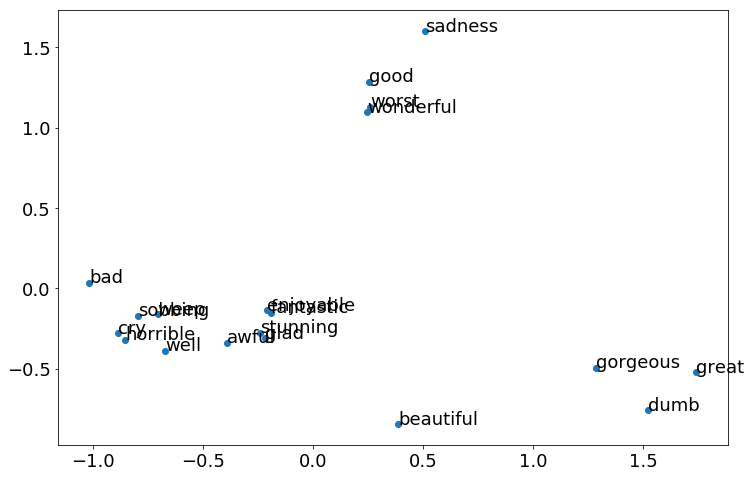

After


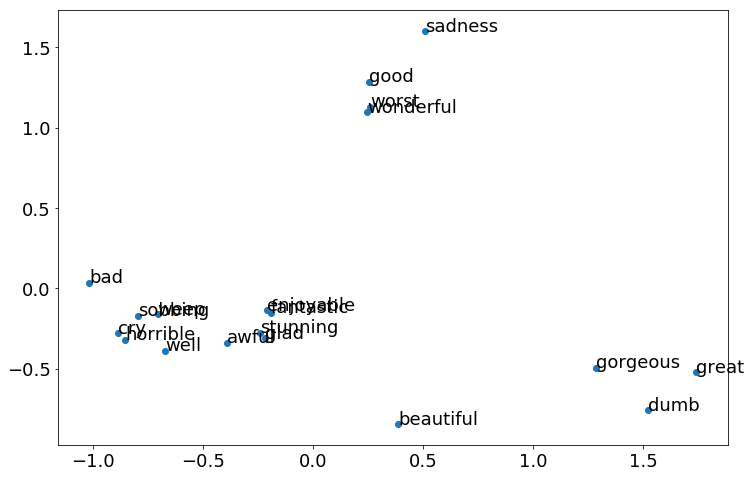

In [27]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, original_embeddings, original_word_dict)
print("After")
draw_plot(words, final_embeddings, word_dict)

# Plot loss/epoch and acc/epoch

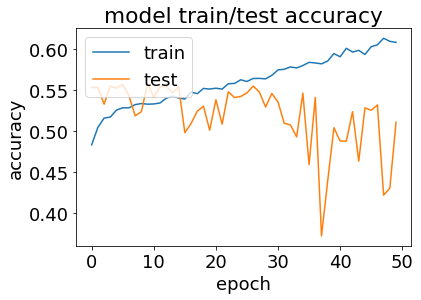

In [28]:
import matplotlib.pyplot as plt

# summarize history for accuracy  
plt.plot(train_accuracy_list)  
plt.plot(test_accuracy_list)  
plt.title('model train/test accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig('train_test_accuracy.png')


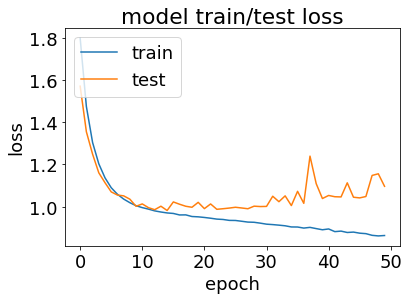

In [29]:
# summarize history for loss  
plt.plot(train_loss_list)  
plt.plot(test_loss_list)  
plt.title('model train/test loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.savefig('train_test_loss.png')